# Our First Receiver

This notebook reviews the matched filter and slicer used by the receiver and provides NumPy functions to implement them.

A complete communications example demonstrates the operation of transmitter and receiver.

In the process, we introduce simulated AWGN (additive, white Gaussian noise) channels and the notion of signal-to-noise ratio.

In [1]:
# import standard libraries",
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "talk"
sns.set_theme(context=sns_context, style="ticks")

In [2]:
## imports from the comms module
from comms.sources import string_source, string_sink
from comms.pulse_shaping import rect_pulse, sine_squared_pulse, manchester_pulse, pulse_shape
from comms.mod_mapping import mod_mapper, PAM4, energy_per_bit, BPSK
from comms.utils import int_to_bits

## Generate a signal for testing

To begin, we synthesize a short signal for demonstrating the receiver processing:

* 16 bits from ASCII `Hi`
* 4-PAM modulation produces 8 symbols
* rectangular pulse shaping with $f_sT=64$ samples per symbol period

Noise is added to the transmitted signal to produce the received signal:
* noise samples have a Gaussian (Normal) distribution (Numpy function `np.random.randn()`)
* the strength (variance) of the noise is set so that the signal is 20 times stronger than the noise
  - the signal-to-noise ratio (SNR) is 20

In [3]:
## Generate a test signal
# transmitted signal
fsT = 64

bits = string_source('Hi')
symbols = mod_mapper(bits, PAM4)
pulse = rect_pulse(fsT)
tx_sig = pulse_shape(symbols, pulse, fsT)

# add noise
SNR = 20
noise_var = energy_per_bit(PAM4) / SNR 
noise_samples = np.sqrt(noise_var) * np.random.randn(len(tx_sig))

# received signal
rx_sig = tx_sig + noise_samples

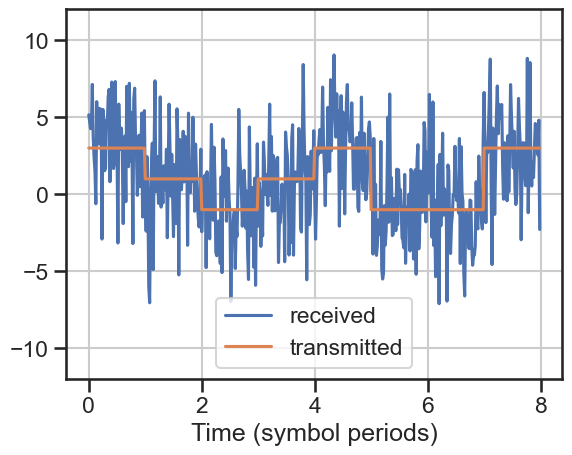

In [4]:
## plot signals
# for plotting, scale signals by sqrt(fsT) so that TX amplitudes match symbol values;
# this does not change the SNR
tt = np.arange(len(tx_sig))/fsT
plt.plot(tt, np.sqrt(fsT)*rx_sig.real, label='received')
plt.plot(tt, np.sqrt(fsT)*tx_sig.real, label='transmitted')

plt.ylim(-12, 12)
plt.grid()
plt.legend()
plt.xlabel('Time (symbol periods)')

plt.show()

The received signal is very noisy - it is hard to discern the underlying transmitted signal. Admittedly, the high oversampling factor ($f_sT=64$) contributes to the large noise amplitudes.

## The matched filter

* The received signal $R(t)$ is first processed by the matched filter (for the pulse shape $p(t)$).

* The matched filter for pulse $p(t)$ has impulse response $h_{MF}(t) = p(-t)$.

* Symbol estimates $\hat{s}_n$ are obtained by sampling the output of the matched filter at $t=nT$, where $T$ is the symbol period:
$$
\hat{s}_n = \left. R(t) \ast p(-t) \right|_{t=nT} = \int R(\tau) p(\tau - nT) \; d\tau.
$$


### Discrete-time matched filter

* When working with samples $R[m]$ of the received signal, the discrete-time matched filter works the same way.

* The impulse response of the discrete-time matched filter is $h_{MF}[m] = p[-m]$.

* Passing the received samples $R[m]$ through this filter yields the signal $z[m] = R[m] \ast p[-m]$.

* The symbol estimates $\hat{s}_n$ are obtained by *sub-sampling* the matched filter output signal $z[m]$, every $f_sT$-th sample of the matched filter output is retained:
$$
\hat{s}_n = z[n \cdot f_sT],
$$


#### Making the matched filter causal

* In this formulation, the matched filter is **not** causal; the impulse response $h_{MF}[m]$ is non-zero for $m<0$.
  - this is a consequence of the time-reversal $p(-t)$
* The filter is easily made causal by delaying the impulse response such that it is purely right-sided.
  - this actually happens "automatically" since there is no time-axis associated with the samples of $p[-m]$
  - the delay $d$ is equal to the length of the filter minus one.
* The consequence of delaying the impulse response is a corresponding delay in the output of the matched filter
  - Hence, the first sub-sample of the matched filter output should be $z[d]$ instead of $z[0]$
  - The estimate of the $n$-th symbol is $\hat{s}_n = z[d + n \cdot f_sT]$

We can capture these considerations in a function that implements matched filtering for a given pulse shape $p[m]$

In [5]:
def matched_filter(sig, pulse, fsT, do_sub_sample=True):
    """matched filter received signal with given pulse
    
    Inputs:
    -------
    `sig`: samples of the received signal
    `pulse`: transmit pulse; assumed to be unit energy
    `fsT`: oversampling factor
    `do_sub_sample`: if True, sub-sampling is performed and only the symbol estimates are output; otherwise the entire matched filter output is computed (default: True)

    Returns:
    --------
    vector representing either the symbol estimates or the matched filter output signal
    """
    # time-reverse the pulse
    h_MF = np.flip(pulse)

    # compute output of the matched filter
    z = np.convolve(sig, h_MF)

    # sub-sample, if needed
    if do_sub_sample:
        delay = len(pulse) - 1
        z = z[delay::fsT]
    

    return z


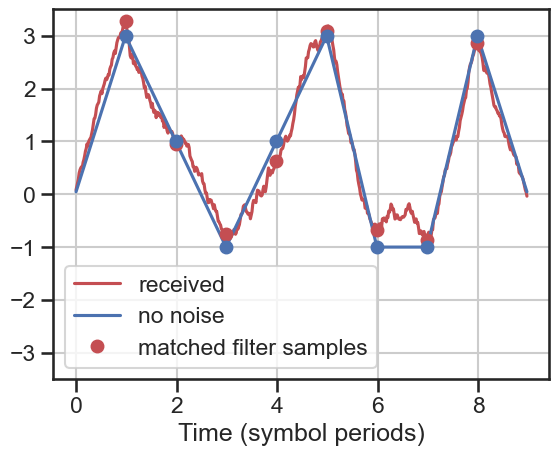

In [6]:
## matched filter
# pass both the received and transmitted signals through the matched filter and plot the results
mf_out_rx = matched_filter(rx_sig, pulse, fsT, False)
mf_out_tx = matched_filter(tx_sig, pulse, fsT, False)

tt = np.arange(len(mf_out_rx))/fsT

plt.plot(tt, mf_out_rx.real,'r-', label='received')
plt.plot(tt, mf_out_tx.real, 'b-', label='no noise')

# sub-sample and mark on the plot
plt.plot(tt[fsT-1::fsT], mf_out_rx.real[fsT-1::fsT], 'ro', label='matched filter samples')
plt.plot(tt[fsT-1::fsT], mf_out_tx.real[fsT-1::fsT], 'bo')

plt.ylim(-3.5, 3.5)
plt.grid()
plt.legend()
plt.xlabel('Time (symbol periods)')

plt.show()

### Experiment 

Let's take a closer look at the sub-sampled matched filter outputs.

Recall that a 4-PAM constellation was used by the transmitter: `{0b00: 1, 0b01: 3, 0b10: -1, 0b11: -3}`

The eight sub-sampled matched filter outputs are:

In [7]:
hat_s = matched_filter(rx_sig, pulse, fsT, True) # True isn't needed since it's the default

hat_s

array([ 3.28772399+0.j,  0.94905297+0.j, -0.75668786+0.j,  0.62715729+0.j,
        3.09403065+0.j, -0.68382387+0.j, -0.85864748+0.j,  2.86865817+0.j])

**Question:** What should the receiver do with these values?

## Slicer/Demodulator

* The slicer takes the sub-sampled matched filter outputs and determines which symbol was most likely transmitted.
   - The receiver knows which constellation was used by the transmitter
* to make this decision, the slicer finds the symbol that is closest the the received, estimated symbol $\hat{s}_n$.
   - for each symbol $s_n$ in the constellation, the slicer computes the squared error $|\hat{s}_n - s_n|^2$.
   - then it picks the symbol that minimizes the squared error
   - more, specifically, it picks the bit pattern that corresponds to the symbol with minimum error
* We can describe the operation of the slicer concisely as follows:
$$
   \hat{i}_n = \arg \min_{i=0,\ldots,2^M-1} |\hat{s}_n - s[i]|^2
$$
* Here:
  - $s[i]$ denotes the symbol corresponding to key $i$ in the constellation
  - the result $\hat{i}_n$ represents the integer representation of the demodulated bit-pattern
    + the utility function `in_to_bits` can be used to convert that integer to a sequence of bits

Here is a function that implements the above considerations.

In [8]:

def demodulator(syms, mod_table):
    """Recover bit sequence from received symbols

    Inputs:
    -------
    * syms: sequence of received (noisy) symbols
    * mod_table: dictionary containing the mapping from groups of bits to symbols

    Returns:
    --------
    a vector of bits
    """
    # how many bits per symbol?
    K = int(np.log2(len(mod_table)))

    # how many bits will we get?
    N = len(syms) * K
    bits = np.zeros(N, dtype=np.uint8)

    # put mod_table's symbol values and keys into a Numpy array
    symbols = np.array(list(mod_table.values()))
    bits_int = np.array(list(mod_table.keys()), dtype=int)

    # find the constellation point closest to received symbol `s`
    for n in range(len(syms)):
        s = syms[n]
        ind = np.argmin(np.abs(symbols - s)**2)  # don't really need the square
        min_k = bits_int[ind]

        # the index of the closest symbol is integer `min_k`
        # convert that to a sequence of K bits
        bits[n * K : (n + 1) * K] = int_to_bits(min_k, K)

    return bits

Use this function to recover the transmitted bit sequence.

In [9]:
rx_bits = demodulator(hat_s, PAM4)
rx_bits

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1], dtype=uint8)

If that is correct, we should be able to get the original message string back.

In [10]:
string_sink(rx_bits)

'Hi'

### Putting it all together

Let's put all the pieces of the transmitter and receiver together and simulate the transmission of a longer message.

We will be using 
* 4-PAM
* sine-squared pulses


In [11]:
## message and system parameters
message = 'ECE 460 is my favorite class'
fsT = 16
pulse = sine_squared_pulse(fsT)
constellation = PAM4

# transmitter
bits = string_source(message)
symbols = mod_mapper(bits, constellation)
tx_sig = pulse_shape(symbols, pulse, fsT)

# channel
SNR = 20
noise_var = energy_per_bit(constellation) /SNR
noise_samples = np.sqrt(noise_var) * np.random.randn(len(tx_sig))

rx_sig = tx_sig + noise_samples

# receiver
hat_s = matched_filter(rx_sig, pulse, fsT)
rx_bits = demodulator(hat_s, constellation)
string_sink(rx_bits)

'ECE 460 ir my fa6orite class'

## To probe further

You are encouraged to experiment with this set-up. Easy things to try are:
* change the SNR and see what impact that has
* change the oversampling factor and verify that it has (little or) no impact on error rates
* change the constellation and see if there is an impact; is that impact related to energy efficiency?
* change the pulse shape and verify that it has no impact on error rates

You may need to be a bit more analytical to measure error rates. You can count bit errors with the code `np.sum(bits != rx_bits)`.